In [58]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pystan
import arviz as az
import pickle
from hashlib import md5

In [59]:
sns.set()

In [60]:
#from Stan tutorial, pickles compiled stan model into cache.
def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm 

In [61]:
#function for getting nicer plots for diagnostics, showing statistical parameters and distributions of data
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label=r'95\% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()

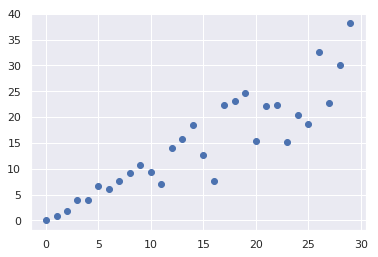

In [62]:
stan_model_lin = """
data{
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters{
    real alpha;
    real beta;
    real<lower=0> epsilon;   
}
model{
    y ~ normal(alpha + beta * x, epsilon);
}
"""
N= 30
x = []
for i in range(0,N):
    l = i
    x.append(l)
    
y = []
for i in range(0,N):
    l = i+np.random.normal(0, 0.2*i)
    y.append(l)


data = {'N':N,
            'x':x,
            'y':y,}

plt.scatter(x,y)
plt.show()

In [63]:
sm = StanModel_cache(model_code = stan_model_lin)
fit = sm.sampling(data=data, iter=1000, chains=4)
print(fit)


Using cached StanModel
Inference for Stan model: anon_model_db4bb94056589e54ef334481ece5b4cc.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.26    0.07   1.68  -3.25  -0.83   0.29   1.38   3.49    558    1.0
beta       1.0  3.9e-3    0.1    0.8   0.94    1.0   1.06    1.2    635    1.0
epsilon   4.46    0.02   0.68   3.36   3.99   4.37   4.85   6.11    950    1.0
lp__    -57.64    0.06    1.4 -61.46 -58.22 -57.26 -56.64 -56.08    582    1.0

Samples were drawn using NUTS at Fri Nov  1 10:46:42 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf448d9400>,
      dtype=object)

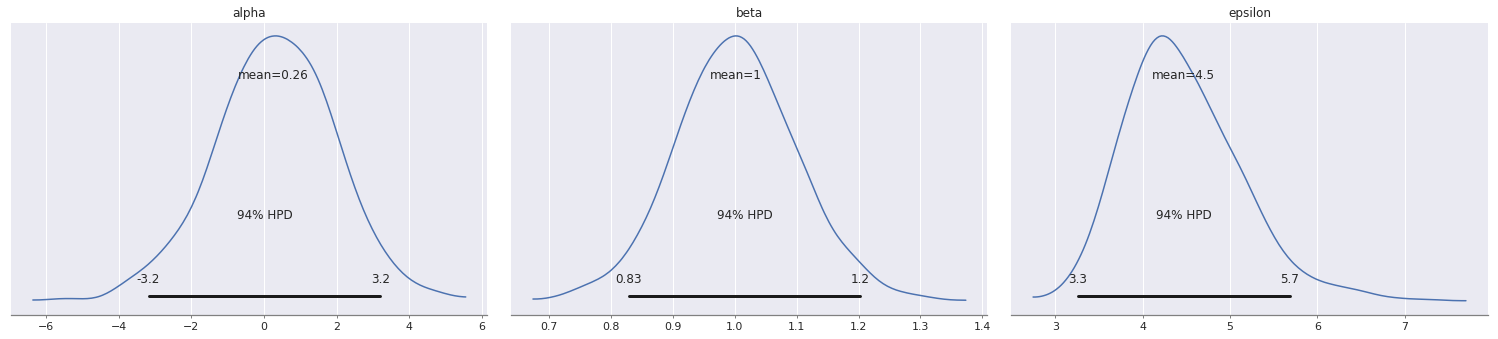

In [64]:
az.plot_posterior(fit)

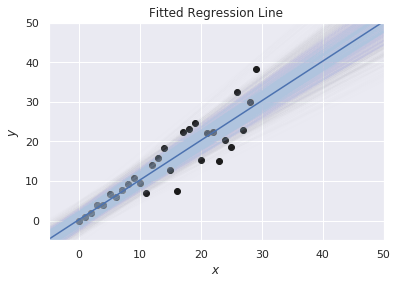

In [65]:
#define variables reading values from fit object from stan evaluation
alpha = fit['alpha']
beta = fit['beta']
epsilon = fit['epsilon']
lp = fit['lp__']

#calculate alpha and beta means
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']


#plot regression line
x_min, x_max = -5, 50
x_plot = np.linspace(x_min, x_max, 100)

#plot a subset of sampled regression lines
np.random.shuffle(alpha), np.random.shuffle(beta)
for i in range(1000):
      plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', 
           alpha=0.015 )

#plot mean regression line, grid, data points
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y, c='k')
plt.grid(True)
plt.ylim(-5,50)
plt.xlim(-5,50)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fitted Regression Line')
plt.show()